# Coding Assignment 1

## Table of Contents

### [Part I](#part1)
#### [Part I: 1. KNN class](#knnclass)
#### [Part I: 2. Handling distance ties and voting ties](#ties)
#### [ Part I: 3. Verification with sklearn KneighborsClassifier class](#match)
### [Part II](#part2)
#### [Part II 1. Linear regression with cut-off value 0.5](#part2_1)
#### [Part II 2. Quadratic regression with cut-off value 0.5](#part2_2)
#### [Part II 3. KNN classification with K chosen by 10-fold cross-validation](#part2_3)
#### [Part II 4. Bayes Rule](#part2_4)

## <a id='part1'>Part I</a>

### Data Generation

Set the model parameters like dimension and standard error, and store the two centers (each is a two-dim vector) in m1 and m2.

In [1]:
import numpy as np
np.random.seed(4721)
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import math
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression

p = 2
s = 1      # sd for generating x   
n = 100    # 2n obs (in total); n from each class       
m1 = [1,0]
m0 = [0,1]

Generate n samples from each normal component. First, we generate a (2n)-by-p matrix with entries being iid samples form a normal dist with mean 0 and variance s-square. Then we form a (2n)-by-p matrix with the first n rows being the two-dimensional vector m1 (the center of the first normal component) and the next n rows being m2. We use command rep to generate repeated rows and use command rbind to stack two matrices vertically together.

In [2]:
n = 100  # generate the train data; n for each class
traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([np.array([m1] * n), np.array([m0] * n)])
Ytrain = np.concatenate(([1]*n, [0]*n))

Generate 2N test samples similarly.

In [3]:
N = 5000
testdata = np.random.normal(size = (2 * N, p)) * s \
           + np.concatenate([np.array([m1] * N), np.array([m0] * N)])
Ytest = np.concatenate(([1]*N, [0]*N))

### Visualization

Let’s take a look of the data. In the plot generated by the code below, points from two groups are colored in red and blue, respectively; the two centers are plotted as +, and a legend is added to explain the association of each color.

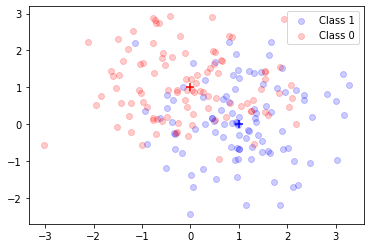

In [4]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[0], m1[1], marker = '+', s = 80, c = "blue")
plt.scatter(m0[0], m0[1], marker = '+', s = 80, c = "red")

plt.legend()
plt.show()

### <a id='knnclass'>Part I: 1. KNN class</a>

In [5]:
import traceback

class KNN:
    def __init__(self, traindata, Ytrain):
        self.traindata = traindata
        self.Ytrain = Ytrain
    
    def get_euclidean_distance(self, testdata, k):
        eucl_dist = []
        point_to_eucl_dist_mapping = {}
        for x, y, z in zip(self.traindata[:,0], self.traindata[:,1], self.Ytrain):
            dist = math.sqrt((x-testdata[0])**2+(y-testdata[1])**2)
            eucl_dist.append(dist)
            point_to_eucl_dist_mapping.update({dist:(x,y,z)})
        closest_dist_points = sorted(eucl_dist)[:k]
        return closest_dist_points, point_to_eucl_dist_mapping
    
    def predict(self, testdata, Ytest, k, prediction_type):
        pred = np.array([])
        prob_class_1 = np.array([])
        for test_point in testdata:
            closest_dist_points, point_to_eucl_dist_mapping = self.get_euclidean_distance([test_point[0], test_point[1]], k)
            point_pred = np.array([])
            for pt in closest_dist_points:
                point_pred = np.append(point_pred, np.array([point_to_eucl_dist_mapping[pt][2]]))
            point_prob = np.sum(point_pred)/k
            prob_class_1 = np.append(prob_class_1, np.array([point_prob]))
            if point_prob>0.5:
                pred = np.append(pred, np.array([1]))
            else:
                pred = np.append(pred, np.array([0]))
        
        if prediction_type == 'prob':
            return prob_class_1
        elif prediction_type == 'class':
            return pred
        else:
            raise TypeError("Mention the prediction type as 'prob' or 'class'")
    
    def accuracy(self, pred, Ytest):
        accuracy = np.sum(pred==Ytest)/len(Ytest)
        return accuracy
    
    def confusion_matrix(self, pred, Ytest):
        TP = sum((pred==1) & (Ytest==1))
        TN = sum((pred==0) & (Ytest==0))
        FP = sum((pred==1) & (Ytest==0))
        FN = sum((pred==0) & (Ytest==1))
        
        return np.matrix([[TP, FP],
                        [FN, TN]])

#### Method for predict
- Predict method returns class or probabilities based on the prediction type mentioned in the function call.

In [6]:
my_knn_mod = KNN(traindata, Ytrain)
pred = my_knn_mod.predict(testdata=testdata, Ytest=Ytest, k=5, prediction_type = 'class')

#### Method for accuracy
- $Accuracy = \frac{TP+TN}{TP+FP+FN+TN} = \frac{Correct Prediction}{Total Test Samples}$

In [7]:
my_knn_mod.accuracy(pred, Ytest)

0.7151

#### Method for confusion matrix
- Since there are only two classes here, below confusion matrx depicts the output of the confusion matrix method of KNN class

<img src="https://statisticallearning.org/img/conf-mat.png" width="30%">

In [8]:
my_knn_mod.confusion_matrix(pred, Ytest)

matrix([[3605, 1454],
        [1395, 3546]])

### <a id='ties'>Part I: 2. Handling distance ties and voting ties</a>
- Distance Tie
    - When there is a distance tie, the algorithm randomly picks the top k items closes to the datapoint.
    - If the distance tie is not on the farthest K, the datapoints having distance ties and closer the test data than farthest K are included by default.
    - Since the distance calculated is euclidian distance, the probability of getting a distance tie is very low, but if the datapoints become infinite, chances of distance ties increases.
   
   
- Voting Tie
    - Whenever there are equal number of datapoints belonging to different classes, the probability value will become 0.5.
    - In such scenario, the algorithm will predict the class as 0 because the condition is that if prob is greater than 0.5, we predict it as class 1.
    - We can modify this probability threshold based on our analysis or prior knowledge about the data.

### <a id='match'> Part I: 3. Verification with sklearn KneighborsClassifier class</a>
- The accuracy obtained by custom KNN class and the sklearn KneighborsClassifier class matches 100%.
- Note: sklearn uses different convention for confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


 k: 1 ; Custom KNN Accuracy: 0.6663 ; Sklearn KNN Accuracy: 0.6663


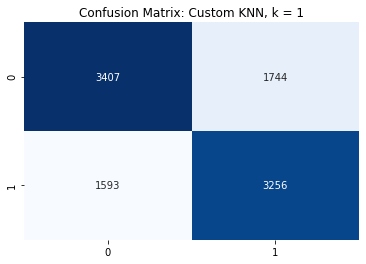

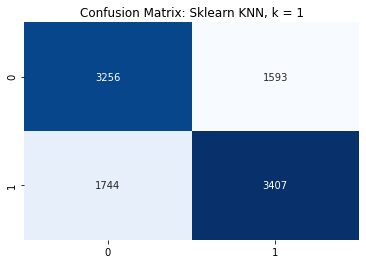


 k: 3 ; Custom KNN Accuracy: 0.7048 ; Sklearn KNN Accuracy: 0.7048


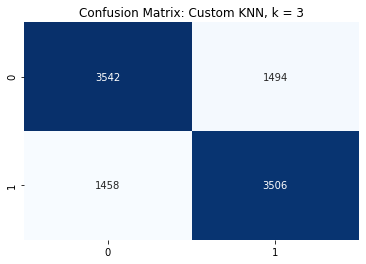

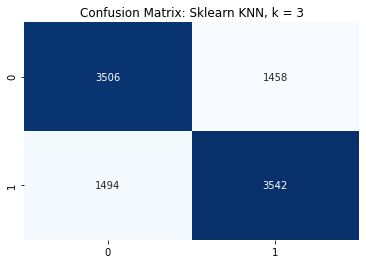


 k: 5 ; Custom KNN Accuracy: 0.7151 ; Sklearn KNN Accuracy: 0.7151


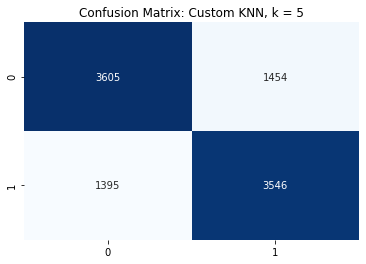

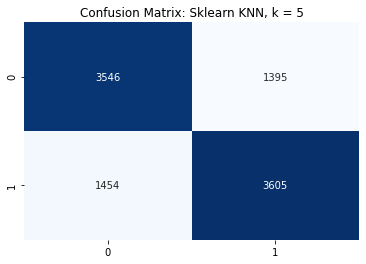

In [9]:
K = [1, 3, 5]


for k in K:
    # accuracy using custom KNN
    my_knn_mod = KNN(traindata, Ytrain)
    pred = my_knn_mod.predict(testdata=testdata, Ytest=Ytest, k=k, prediction_type = 'class')
    acc_custom_knn = my_knn_mod.accuracy(pred, Ytest)
    conf_mat_custom_knn = my_knn_mod.confusion_matrix(pred, Ytest)
    
    # accuracy using sklearn KNN class
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(traindata, Ytrain)
    acc_sklearn_knn = knn.score(testdata, Ytest)
    conf_mat_sklearn_knn = confusion_matrix(knn.predict(testdata), Ytest)
    
    print('\n k:', k, '; Custom KNN Accuracy:', acc_custom_knn, '; Sklearn KNN Accuracy:', acc_sklearn_knn)
    
    plt.title(f'Confusion Matrix: Custom KNN, k = {k}')
    sn.heatmap(conf_mat_custom_knn, annot=True,  fmt='.0f', cmap="Blues", cbar=False)
    plt.show()
    
    plt.title(f'Confusion Matrix: Sklearn KNN, k = {k}')
    sn.heatmap(conf_mat_sklearn_knn, annot=True,  fmt='.0f', cmap="Blues", cbar=False)
    plt.show()

## <a id='part2'>Part II</a>

### Data Generation
Generate the 20 centers, 10 for each group.

In [10]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training data.

In [11]:
def generate_data():
    n=100;  
    # Randomly allocate the n samples for class 1  to the 10 clusters
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)


    # sd for generating x  
    s = np.sqrt(float(1)/5) 

    traindata = np.random.normal(size = (2 * n, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    ytrain = np.concatenate(([1]*n, [0]*n))
    
    n=5000;  
    # Randomly allocate the n samples for class 1  to the 10 clusters
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)


    # sd for generating x  
    s = np.sqrt(float(1)/5) 

    testdata = np.random.normal(size = (2 * n, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    ytest = np.concatenate(([1]*n, [0]*n))
    
    return traindata, ytrain, testdata, ytest

In [12]:
datasets = [generate_data() for dset in range(50)]

In [13]:
datasets[0][2]

array([[ 1.5118858 ,  1.3200704 ],
       [ 0.41296916,  0.80578313],
       [ 1.48598828,  1.10754466],
       ...,
       [-0.31098616, -0.90931784],
       [ 2.12828709, -0.59020916],
       [ 1.83734942,  1.71267387]])

### Visualization

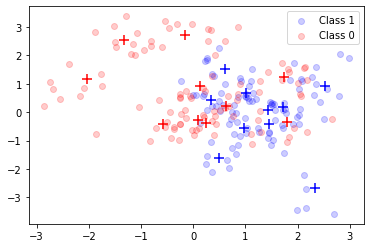

In [14]:
n = 100
plt.scatter(datasets[0][0][:n, 0], datasets[0][0][:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(datasets[0][0][n:, 0], datasets[0][0][n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

### <a id='part2_1'>Part II 1. Linear regression with cut-off value 0.5</a> 

In [15]:
lin_mod_trn_error = []
lin_mod_tst_error = []

for i in range(50):
    lin_mod = LinearRegression().fit(datasets[i][0], datasets[i][1])
    lin_mod_pred_trn = lin_mod.predict(datasets[i][0])
    lin_mod_pred_tst = lin_mod.predict(datasets[i][2])
    lin_mod_pred_trn = [1 if y > 0.5 else 0 for y in lin_mod_pred_trn]
    lin_mod_pred_tst = [1 if y > 0.5 else 0 for y in lin_mod_pred_tst]
    lin_mod_trn_err = sum(lin_mod_pred_trn != datasets[i][1])/len(datasets[i][1])
    lin_mod_tst_err = sum(lin_mod_pred_tst != datasets[i][3])/len(datasets[i][3])
    
    lin_mod_trn_error.append(lin_mod_trn_err)
    lin_mod_tst_error.append(lin_mod_tst_err)

### <a id='part2_2'>Part II 2. Quadratic regression with cut-off value 0.5</a> 

### <a id='part2_3'>Part II 3. KNN classification with K chosen by 10-fold cross-validation</a>

In [28]:
# return traindata, ytrain, testdata, ytest

In [19]:
def knn_score(k, trn, tst, ytrn, ytst):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trn, ytrn)
    acc_sklearn_knn = knn.score(tst, ytst)
    
    return acc_sklearn_knn

In [20]:
tst_idx = [np.arange(i*20, i*20+int(200/10), 1) for i in range(10)]
k_cross_val_acc = {}
for k in range(1,180):
    k_acc = []
    for tst_id in tst_idx:
        add_ids = np.arange(0,200,1)
        trn_ids = [id not in tst_id for id in add_ids]
        acc = knn_score(k, datasets[0][0][trn_ids], datasets[0][0][tst_id],  datasets[0][1][trn_ids],
                  datasets[0][1][tst_id])
        k_acc.append(1-acc)
    k_cross_val_acc.update({k:np.average(k_acc)})

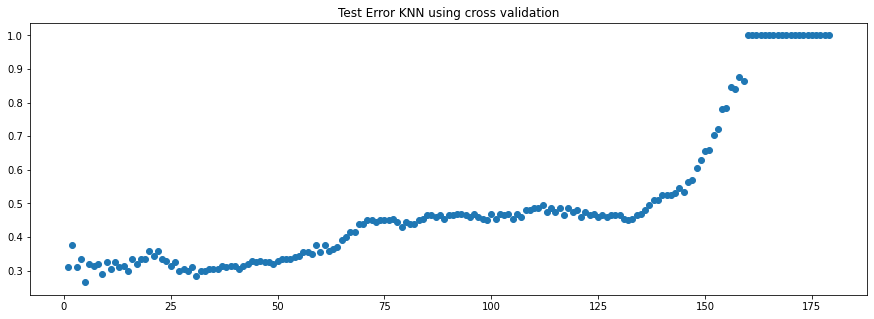

In [30]:
plt.figure(figsize=(15,5))
plt.title('Test Error KNN using cross validation')
plt.scatter(k_cross_val_acc.keys(), k_cross_val_acc.values())
plt.show()

In [22]:
min(k_cross_val_acc.values())

0.265

In [23]:
for key, val in k_cross_val_acc.items():
    if k_cross_val_acc[key] == min(k_cross_val_acc.values()):
        print(key)
        break

5


In [24]:
print('minimum test error using KNN', min(k_cross_val_acc.values()), 'when k is 5.')

minimum test error using KNN 0.265 when k is 5.


In [25]:
k_cross_val_acc[5]

0.265

In [26]:
[{k:k_cross_val_acc[k]} for k in range(1,25)]

[{1: 0.30999999999999994},
 {2: 0.375},
 {3: 0.31},
 {4: 0.3350000000000001},
 {5: 0.265},
 {6: 0.32},
 {7: 0.315},
 {8: 0.32},
 {9: 0.29},
 {10: 0.32500000000000007},
 {11: 0.30500000000000005},
 {12: 0.325},
 {13: 0.31},
 {14: 0.31500000000000006},
 {15: 0.3},
 {16: 0.335},
 {17: 0.31999999999999995},
 {18: 0.335},
 {19: 0.335},
 {20: 0.36},
 {21: 0.345},
 {22: 0.36},
 {23: 0.335},
 {24: 0.33}]

Note: it is possible that there are multiple K values that give the smallest CV error; when this happens, we should pick the largest one among them, since the larger the K value, the simplier the model with low variance.

In [27]:
knn_mod_trn_error = []
knn_mod_tst_error = []

for i in range(50):
    knn_mod_trn_err = 1 - knn_score(13, datasets[i][0], datasets[i][0],
                                      datasets[i][1], datasets[i][1])
    knn_mod_tst_err = 1 - knn_score(13, datasets[i][0], datasets[i][2],
                                      datasets[i][1], datasets[i][3])
    
    knn_mod_trn_error.append(knn_mod_trn_err)
    knn_mod_tst_error.append(knn_mod_tst_err)

### <a id = 'part2_4'>Part II 4. Bayes Rule</a>

<img src="https://campuspro-uploads.s3.us-west-2.amazonaws.com/497eef81-a2cf-4d1c-923e-22a7e4dcb092/ea022e43-c03e-42c9-bdc7-63d17aac7285/image.png" width="60%">

In [259]:
def myfun(x):
    return 2*np.dot(x, np.subtract(m1, m0)) - (np.dot(m1, m1) - np.dot(m0, m0))

# Ytest_pred_Bayes = [myfun(x) > 0 for x in testdata]
# test_err_Bayes = sum(Ytest !=  Ytest_pred_Bayes) / float(2*N)

<h2 style="color:red">Mean errors, standard errors</h2>